<a href="https://colab.research.google.com/github/srishagorasa1/Seattle-Rain-Prediction/blob/main/SeattleRainPrediction2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **An Analysis regarding Rain Forecast in Seattle provided by an Atmospheric Scientist**

**Objective:**

The input dataset (seattleWeather_1948-2017.csv) provides information on a few Meteorological variables in Seattle from 1948 to 2017. The customer would like to know the likelihood of predicting whether it rains or not on a specific day by using MLAs.

The input variables (predictors) are Date, PRCP, TMAX, and TMIN. The last three are numerical continuous variables.

The outcome or dependent variable is: RAIN (boolean)

I will use knowledge and experience in the field of Atmospheric Science to improve the methodology, but an in-depth use of science is not possible in this framework.

In part 1, I only used the available predictors (as they are) and dropped the ones that are not independent. That way, I reached an accuracy score of 68%.

Here, (part 2), I will perform advanced feature engineering and will extract new variables based on the available predictors in order to improve the accuracy score.

Variable 'PRCP' (precipitation amount) should be used with caution:

Correct use of PRCP as a predictor:

1) We know PRCP in the last few days (e.g. 1-3 Jan.). How can that help predict 'RAIN' (binary rain: did it rain or not) for today (e.g. 4 Jan.)?

2) We know the PRCP for 4 Jan. for all the previous years 1948-2017. Can we use this data to predict 'RAIN' for 4 Jan. 2018?

Wrong use of PRCP:

We know PRCP for 4 Jan. 2018. Can we use it to predict 'RAIN' for 4 Jan. 2018?

This is cheating: MLA would provide a perfect answer when the outcome is included among the predictors: when MLA knows the amount of precipitation on a specific day, it can certainly say whether it rains or not.

Note that the other solutions to this problem, that I found on this website, did this mistake and kept the variable PRCP to predict RAIN. This motivated me to provide a better methodology.

**Importing important libraries**

In [32]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sb
import os

from pandas import Series, DataFrame
from pylab import rcParams
from sklearn import preprocessing

from sklearn import metrics
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

**Reading the data:**

In [33]:
met_df = pd.read_csv('seattleWeather_1948-2017.csv')
print(met_df.head()); print(); print()
met_df.info()

         DATE  PRCP  TMAX  TMIN  RAIN
0  1948-01-01  0.47    51    42  True
1  1948-01-02  0.59    45    36  True
2  1948-01-03  0.42    45    35  True
3  1948-01-04  0.31    45    34  True
4  1948-01-05  0.17    45    32  True


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25551 entries, 0 to 25550
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DATE    25551 non-null  object 
 1   PRCP    25548 non-null  float64
 2   TMAX    25551 non-null  int64  
 3   TMIN    25551 non-null  int64  
 4   RAIN    25548 non-null  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 998.2+ KB


The description and unit of each variable:

DATE = the date of the observation

PRCP = the amount of precipitation, in inches

TMAX = the maximum temperature for that day, in degrees Fahrenheit

TMIN = the minimum temperature for that day, in degrees Fahrenheit

RAIN = TRUE if rain was observed on that day, FALSE if it was not

**Data Cleaning:**

**Step 1: Correcting wrong values or outliers:**

In [34]:
met_df.describe(include = 'all')

,DATE,PRCP,TMAX,TMIN,RAIN
count,25551,25548.000000,25551.000000,25551.000000,25548
unique,25551,NaN,NaN,NaN,2
top,1975-04-29,NaN,NaN,NaN,False
freq,1,NaN,NaN,NaN,14648
mean,NaN,0.106222,59.544206,44.514226,NaN
std,NaN,0.239031,12.772984,8.892836,NaN
min,NaN,0.000000,4.000000,0.000000,NaN
25%,NaN,0.000000,50.000000,38.000000,NaN
50%,NaN,0.000000,58.000000,45.000000,NaN
75%,NaN,0.100000,69.000000,52.000000,NaN


The data description makes sense, and the mean, min, and max values of each variable is reasonable meaning there should not be a mistake in the data (such as a very large temperature of 200 F).

**Step 2: Inputing missing values:**

There are only three missing data points for each PRCP and RAIN. So, we use median for PRCP and mode for RAIN to fill in the gaps.

In [35]:
met_df.isna().sum()

DATE    0
PRCP    3
TMAX    0
TMIN    0
RAIN    3
dtype: int64

In [36]:
P_median = met_df.PRCP.median()
R_mode   = met_df.RAIN.mode()[0]

met_df.PRCP.fillna(P_median, inplace = True)
met_df.RAIN.fillna(R_mode, inplace = True)

met_df.isna().sum()

DATE    0
PRCP    0
TMAX    0
TMIN    0
RAIN    0
dtype: int64

**Step 3: Converting boolean variable to dummy variable:**

We should change RAIN from True/False to 1/0.

We then replace the new variable with the original one.

In [37]:
from sklearn.preprocessing import LabelEncoder
RAIN_encode = LabelEncoder().fit_transform(met_df.RAIN)
RAIN_encode

array([1, 1, 1, ..., 0, 0, 0])

In [38]:
met_df['RAIN'] = RAIN_encode

met_df.describe(include = 'all')

,DATE,PRCP,TMAX,TMIN,RAIN
count,25551,25551.000000,25551.000000,25551.000000,25551.000000
unique,25551,NaN,NaN,NaN,NaN
top,1975-04-29,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN
mean,NaN,0.106209,59.544206,44.514226,0.426598
std,NaN,0.239020,12.772984,8.892836,0.494592
min,NaN,0.000000,4.000000,0.000000,0.000000
25%,NaN,0.000000,50.000000,38.000000,0.000000
50%,NaN,0.000000,58.000000,45.000000,0.000000
75%,NaN,0.100000,69.000000,52.000000,1.000000


**Step 4: Change DATE variable to datetime format:**

In [39]:
date = pd.to_datetime(met_df.DATE, format="%Y-%m-%d")
met_df['DATE'] = date
met_df.head()

,DATE,PRCP,TMAX,TMIN,RAIN
0,1948-01-01,0.47,51,42,1
1,1948-01-02,0.59,45,36,1
2,1948-01-03,0.42,45,35,1
3,1948-01-04,0.31,45,34,1
4,1948-01-05,0.17,45,32,1


**Step 5: feature engineering:**

Now, I am going to use subject matter expertise to extract new features (based on available data).

TMAX and TMIN are highly correlated, and at least one of them should be dropped, but is there a way to deduce new variables that have a higher correlation with RAIN and at the same time keep information from both TMAX and TMIN? I can think of (T_DIFF = TMAX - TMIN); and (T_RATIO = TMAX / TMIN). These new variables should have a higher correlation with 'RAIN', because when it rains there is less fluctuation in the daily change of Temperature, and TMAX and TMIN get closer. Therefore, T_DIFF (T_RATIO) becomes smaller (larger). This theory will be tested later. I will only use T_RATIO in this demo.

It takes about a week for a meteorological weather system to pass over a certain location. Consider a system is causing rain over Seattle for a week. I simply assume the average state, meaning that today is the 4th rainy day due to this system. In other words, the last 3 days were rainy and the next 3 days will also be rainy. So, I conclude that if I know the PRCP in the past 3 days, I can predict the RAIN for today. Therefore, I extract a variable "average precipitation in the past n days" (PRCP_n) where n = 3. For example, I know the average PRCP for 1-3 Jan. 2017. What is the predicted RAIN for Jan. 4 2017?

Imagine today is 4 Jan. 2018. If 4 Jan. was rainy in all previous years, there is a good chance that it will rain today. I would like to use average PRCP for 4 Jan. from 1948 to 2017 and predict RAIN for today. So, I calculate a new variable daily_PRCP (average PRCP on a specific day for all years).

In [40]:
## T_RATIO
T_RATIO =  met_df.TMIN / met_df.TMAX
T_RATIO[T_RATIO > 1]  = 1 #correcting an error in initial data where TMIN > TMAX

## PRCP in the past n days (here, n = 3)
n = 3
PRCP_n = np.empty(len(met_df.PRCP))
PRCP_n[:] = 0
PRCP_n = [sum(met_df.PRCP.values[i-n:i]) / n for i in range(n, len(met_df.PRCP.values))]

## daily PRCP
from datetime import datetime
DoY_str = met_df.DATE.dt.strftime('%j')
Day_of_Year = [int(a) for a in DoY_str]
#group data based on "day of year"
groupD     = met_df.groupby(Day_of_Year)
DoY_PRCP   = groupD['PRCP'].mean()  # daily climatological mean PRCP
daily_PRCP = [DoY_PRCP[a] for a in Day_of_Year]

In [41]:
# Add all these new variables to DataFrame:
T_RATIO_df     = pd.DataFrame(T_RATIO,     columns = ['T_RATIO'])
PRCP_n_df      = pd.DataFrame(PRCP_n,      columns = ['PRCP_n'])
daily_PRCP_df  = pd.DataFrame(daily_PRCP,  columns = ['daily_PRCP'])

met_new_df = pd.concat([met_df['DATE'],met_df['PRCP'],PRCP_n_df,daily_PRCP_df,
                        met_df['TMAX'],met_df['TMIN'],T_RATIO_df,met_df['RAIN']], axis = 1)

met_new_df.PRCP_n.fillna(met_new_df.PRCP.median(), inplace = True)

met_new_df.describe(include = 'all')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  # This is added back by InteractiveShellApp.init_path()


,DATE,PRCP,PRCP_n,daily_PRCP,TMAX,TMIN,T_RATIO,RAIN
count,25551,25551.000000,25551.000000,25551.000000,25551.000000,25551.000000,25551.000000,25551.000000
unique,25551,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,1968-11-10 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,1948-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2017-12-14 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,0.106209,0.106189,0.106209,59.544206,44.514226,0.753182,0.426598
std,NaN,0.239020,0.169752,0.066588,12.772984,8.892836,0.084432,0.494592
min,NaN,0.000000,0.000000,0.002857,4.000000,0.000000,0.000000,0.000000
25%,NaN,0.000000,0.000000,0.049286,50.000000,38.000000,0.694444,0.000000


**Exploratory Data Analysis:**

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


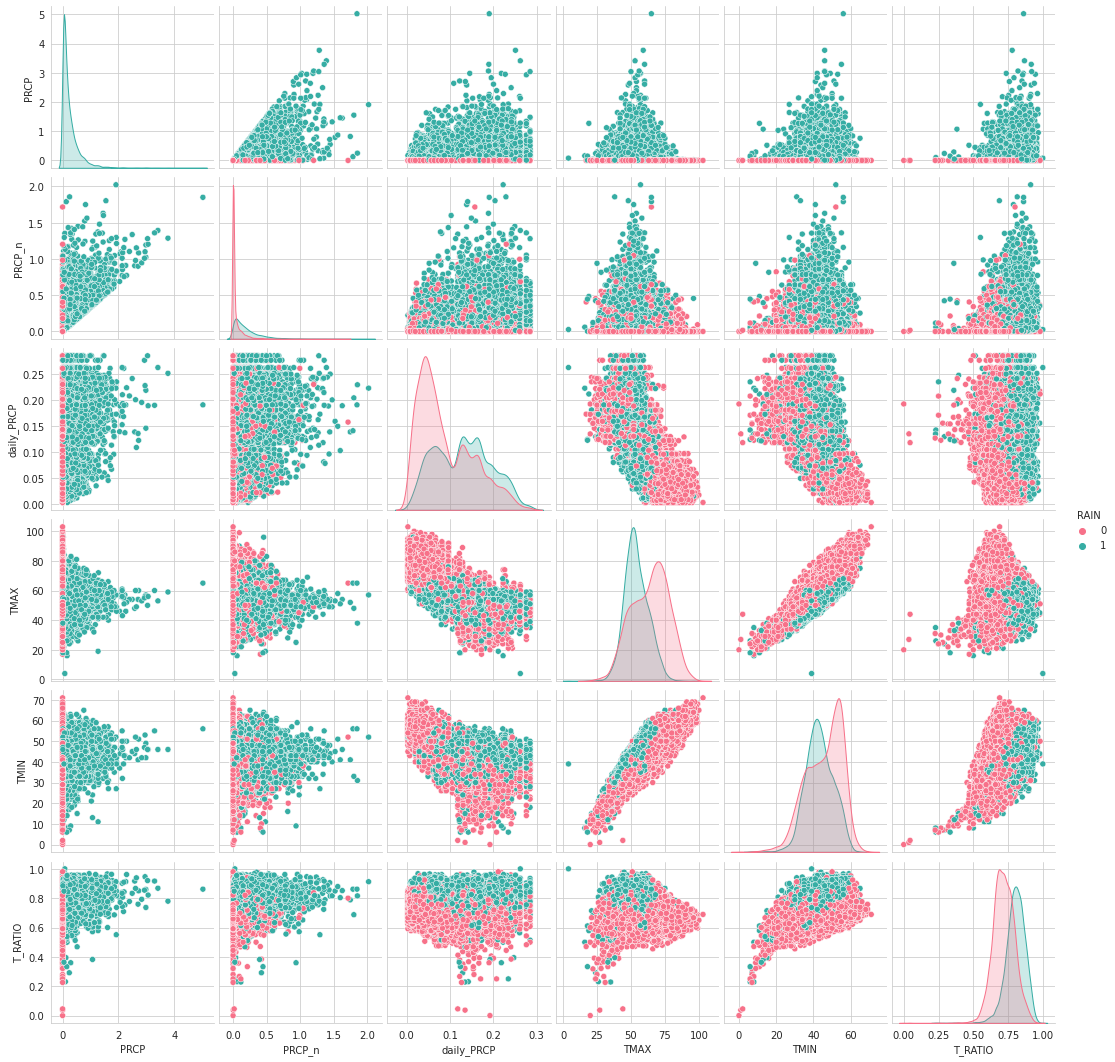

In [42]:
%matplotlib inline
rcParams['figure.figsize'] = 10, 8
sb.set_style('whitegrid')

sb.pairplot(met_new_df, palette = 'husl', hue = 'RAIN')
plt.show()

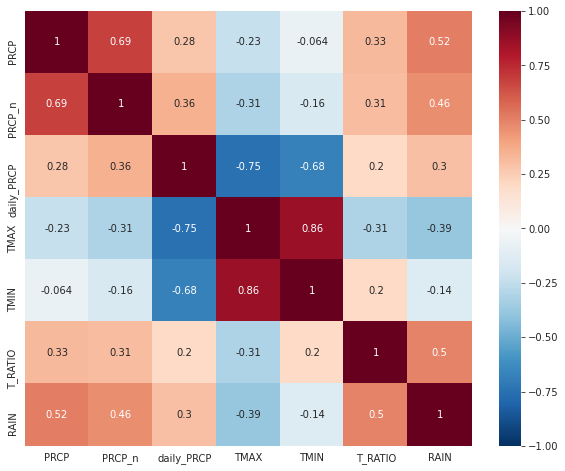

In [43]:
rcParams['figure.figsize'] = 10, 8
sb.heatmap(met_new_df.corr(), vmin=-1, vmax=1, annot=True, cmap = 'RdBu_r')
plt.show()

It seems that the new variabels extracted via feature engineering have high correlation with RAIN.

Compared to TMAX or TMIN, T_RATIO (equals to TMAX / TMIN) has higher correlation with RAIN.

PRCP_n (average precipitation in the past n days, here n = 3) and daily_PRCP (average PRCP on a specific day for all years) also have relatively high correlations with RAIN.

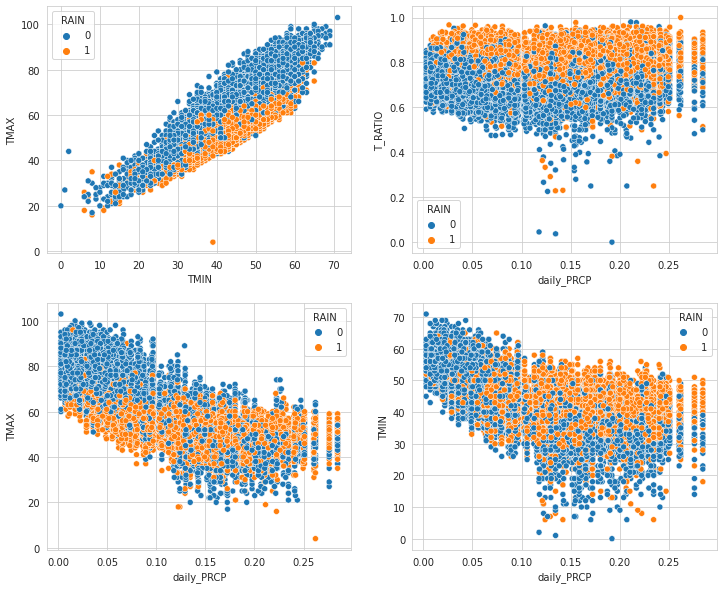

In [44]:
fig, axis = plt.subplots(2, 2,figsize=(12,10))
sb.scatterplot(x = 'TMIN', y ='TMAX', data = met_new_df, hue = 'RAIN', ax = axis[0,0])
sb.scatterplot(x = 'daily_PRCP', y ='T_RATIO', data = met_new_df, hue = 'RAIN', ax = axis[0,1])
sb.scatterplot(x = 'daily_PRCP', y ='TMAX', data = met_new_df, hue = 'RAIN', ax = axis[1,0])
sb.scatterplot(x = 'daily_PRCP', y ='TMIN', data = met_new_df, hue = 'RAIN', ax = axis[1,1])
plt.show()

As expected, TMAX and TMIN are not independent: this means that there are factors such as season, weather systems and sky cloudiness that affect both TMAX and TMIN. Since TMAX and TMIN are dependent features, we should drop one of them.

Also, TMAX and TMIN are highly correlated with the newly-extracted feature (daily_PRCP), due to the fact that both TMAX and TMIN contain information on seasonality. T_RATIO, on the other hand, is not associated with seasonality, and therefore shows no relationship with daily_PRCP.

Since we extracted T_RATIO from TMAX and TMIN, and T_RATIO and daily_PRCP are independent, we keep these two and drop both TMAX and TMIN.

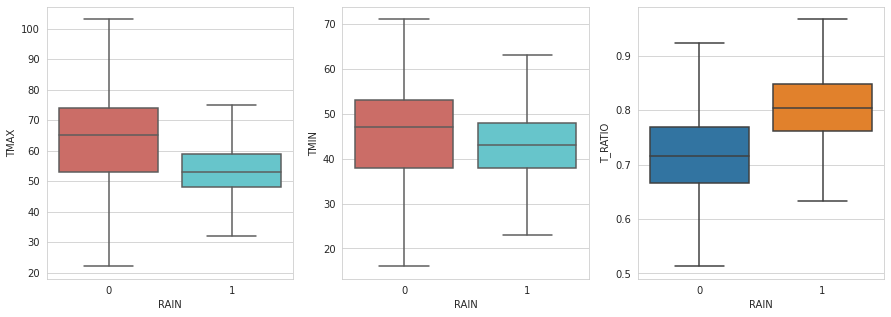

In [45]:
fig, axis = plt.subplots(1, 3,figsize=(15,5))
sb.boxplot(x = 'RAIN', y ='TMAX', data = met_new_df, ax = axis[0], showfliers = False, palette = 'hls')
sb.boxplot(x = 'RAIN', y ='TMIN', data = met_new_df, ax = axis[1], showfliers = False, palette = 'hls')
sb.boxplot(x = 'RAIN', y ='T_RATIO', data = met_new_df, ax = axis[2], showfliers = False)
plt.show()

Both TMAX and TMIN have lower values during rain, because cloud cover blocks solar radiation and causes a decrease in surface warming.

T_RATIO is larger during rain, because the diurnal fluctuaion of temperature is smaller in cloudy days and TMIN and TMAX are closer.

TMAX predicts RAIN better than TMIN does, and T_RATIO predicts RAIN much better than the other two.

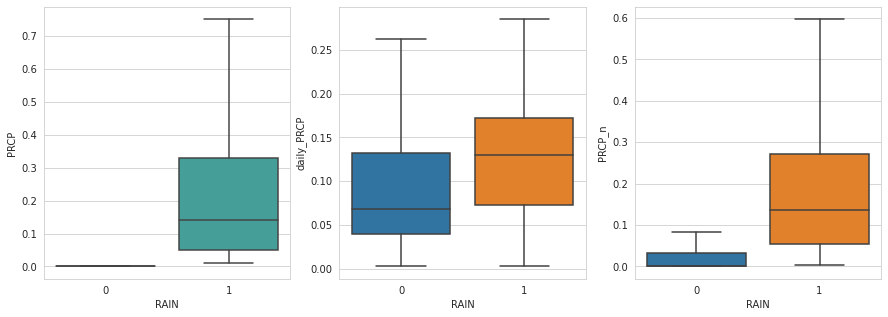

In [46]:
fig, axis = plt.subplots(1, 3,figsize=(15,5))
sb.boxplot(x = 'RAIN', y ='PRCP', data = met_new_df, ax = axis[0], showfliers = False, palette = 'husl')
sb.boxplot(x = 'RAIN', y ='daily_PRCP', data = met_new_df, ax = axis[1], showfliers = False)
sb.boxplot(x = 'RAIN', y ='PRCP_n', data = met_new_df, ax = axis[2], showfliers = False)
plt.show()

The left panel reinforces why PRCP should be dropped as a predictor. When precipitation amount is zero, certainly it is not rainy.

When the average of PRCP for today in all previous years is low, there is a good chance that today will not be rainy, and vice versa.

When the PRCP was low in the past n days (here, n = 3), it is very likely that today will not be rainy, and vice versa.

So, we keep T_RATIO, PRCP_n, and daily_PRCP as predictors, and drop other variables (except RAIN, which is the outcome).

In [47]:
met_new_df.drop(['DATE','PRCP','TMIN','TMAX'], inplace = True, axis=1)
met_new_df.head()

,PRCP_n,daily_PRCP,T_RATIO,RAIN
0,0.493333,0.166571,0.823529,1
1,0.440000,0.234571,0.800000,1
2,0.300000,0.142143,0.777778,1
3,0.306667,0.206571,0.755556,1
4,0.340000,0.210429,0.711111,1


**Implementing MLAs:**

**Spliting the data into test and train sets:**

In [48]:
X_train, X_test, Y_train, Y_test = train_test_split(met_new_df.drop('RAIN', axis=1),
                                                   met_new_df['RAIN'], test_size=0.2, random_state=10)

**Using a variety of MLAs to get the best results**

Since the purpose of this project is determining the best rain prediction, we would like to maximize the accuracy score.

The outcome is binary, so we can use Logistic Regression, Decision Tree, or Naive Bayes.

We also use ensemble algorithms (such as Random Forest) to see if the accuracy score can be improved further.

In [49]:
all_classifiers = {'Gradient Boost': GradientBoostingClassifier(),
                 'Ada Boost': AdaBoostClassifier(),
                 'Random Forest': RandomForestClassifier(n_estimators=50, min_samples_leaf=2, min_samples_split=4, max_depth=6),
                 'Logistic Regression': LogisticRegression(),
                 'Decision Tree' : DecisionTreeClassifier(),
                 'KNN': KNeighborsClassifier(),
                 'Gaussian NB': GaussianNB(),
                 'Beroulli  NB': BernoulliNB(),
                  'SVC': SVC(probability = True)}

In [50]:
ML_name = []
ML_accuracy = []
for Name,classifier in all_classifiers.items():
    classifier.fit(X_train,Y_train)
    Y_pred = classifier.predict(X_test)
    ML_accuracy.append(metrics.accuracy_score(Y_test,Y_pred)) 
    ML_name.append(Name)

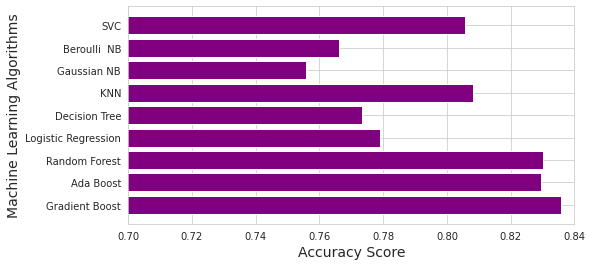

In [51]:
rcParams['figure.figsize'] = 8, 4
plt.barh(ML_name, ML_accuracy, color = 'purple')
plt.xlabel('Accuracy Score', fontsize = '14')
plt.ylabel('Machine Learning Algorithms', fontsize = '14')
plt.xlim([0.7, 0.84])
plt.show()

As expected, ensemble MLAs provide better accuracy.

**Optimizing model hyper-parameters:**

Let's see if we can improve a model performance by changing the hyper parameters.

We are not going to test all the models, but just a few of them.

**Logistic Regression:**

In [52]:
solve       = ['liblinear', 'sag', 'lbfgs']
fit_interc  = [True, False]
interc_scal = [1, 2, 3]
ccc         = [1, 2, 3]

max_score = 0

for so in solve:
    for fi in fit_interc:
        for ins in interc_scal:
            for c in ccc:
                MLA = LogisticRegression(solver=so, fit_intercept=fi, intercept_scaling=ins, C=c)
                MLA.fit(X_train,Y_train)
                Y_pred = MLA.predict(X_test)
                if metrics.accuracy_score(Y_test,Y_pred) > max_score:
                    max_score, so_best, fi_best, ins_best, c_best = metrics.accuracy_score(Y_test,Y_pred), so, fi, ins, c

print('maximum accuracy score, solver, fit_intercept, intercept_scaling, C:')
print(max_score, so_best, fi_best, ins_best, c_best)

maximum accuracy score, solver, fit_intercept, intercept_scaling, C:
0.7814517706906672 liblinear True 1 1


**Decision Tree:**

In [53]:
criteri       = ['gini', 'entropy']
min_samp_lf   = [1, 2, 5, 10]
min_samp_splt = [2, 4, 8, 12]
maxim_depth   = [2, 4, 8, 12, None]

max_score = 0

for c in criteri:
    for ml in min_samp_lf:
        for ms in min_samp_splt:
            for md in maxim_depth:
                MLA = DecisionTreeClassifier(criterion=c, min_samples_leaf=ml, min_samples_split=ms, max_depth=md)
                MLA.fit(X_train,Y_train)
                Y_pred = MLA.predict(X_test)
                if metrics.accuracy_score(Y_test,Y_pred) > max_score:
                    max_score, c_best, l_best, s_best, d_best = metrics.accuracy_score(Y_test,Y_pred), c, ml, ms, md



print('maximum accuracy score, criterion, min_samples_leaf, min_samples_split, max_depth:')
print(max_score, c_best, l_best, s_best, d_best)

maximum accuracy score, criterion, min_samples_leaf, min_samples_split, max_depth:
0.8348659753472901 gini 10 4 8


**Gradient Boosting:**

In [54]:
learn_r       = [1, 2, 3]
min_samp_lf   = [1, 2, 5]
min_samp_splt = [2, 4, 8]
maxim_depth   = [3, 5, 10]

max_score = 0

for c in learn_r:
    for ml in min_samp_lf:
        for ms in min_samp_splt:
            for md in maxim_depth:
                MLA = GradientBoostingClassifier(learning_rate=c, min_samples_leaf=ml, min_samples_split=ms, max_depth=md)
                MLA.fit(X_train,Y_train)
                Y_pred = MLA.predict(X_test)
                if metrics.accuracy_score(Y_test,Y_pred) > max_score:
                    max_score, c_best, l_best, s_best, d_best = metrics.accuracy_score(Y_test,Y_pred), c, ml, ms, md


print('maximum accuracy score, learning_rate, min_samples_leaf, min_samples_split, max_depth:')
print(max_score, c_best, l_best, s_best, d_best)

maximum accuracy score, learning_rate, min_samples_leaf, min_samples_split, max_depth:
0.8352572882019175 1 5 2 3


Although tuning the hyper-parameters does not further increase the score for Gradient Boosting (which had a relatively high score by default) and Logistic Regression (which had a relatively low score by default), it does improve the accuracy score for Decision Tree from 0.77 to 0.83.

**Further Validation for Decision Tree**

**Classification report without cross-validation:**

In [55]:
MLA = DecisionTreeClassifier(criterion='gini', min_samples_leaf=10, min_samples_split=2, max_depth=8)
MLA.fit(X_train,Y_train)
Y_pred = MLA.predict(X_test)
print(metrics.classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.89      0.81      0.85      2888
           1       0.78      0.87      0.82      2223

    accuracy                           0.83      5111
   macro avg       0.83      0.84      0.83      5111
weighted avg       0.84      0.83      0.84      5111



The classification report shows that the NOT RAIN accuracy score is higher than RAIN accuracy score by 3%.

In our test set, the number of NOT RAIN cases is ~ 1.3 times the number of RAIN cases.

**K-fold cross-validation and confusion matrices:**

We use this validation to make sure the accuracy score is not dependent on the train-test split. In other words, we want to verify that the train-test split is random.

In [56]:
CV_scores = cross_val_score(MLA, X_train, Y_train, cv=5)
print ('5-fold cross-validation: scores = ')
print(CV_scores)

5-fold cross-validation: scores = 
[0.83830724 0.8390411  0.82363014 0.82681018 0.83292564]


So, the scores from cross-validation do not vary much, and range between 0.823 and 0.839

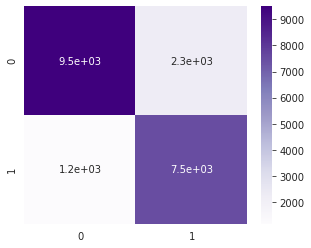

In [57]:
Y_train_pred = cross_val_predict(MLA, X_train, Y_train)
rcParams['figure.figsize'] = 5, 4
sb.heatmap(confusion_matrix(Y_train, Y_train_pred), annot=True, cmap='Pinks')
plt.show()

The result of confusion matrix is good when the values on the upper left and lower right are high and other values are low, which is the case here.

It shows that the cases of false predictions for NOT RAIN (2300) and RAIN (1200) are much lower than cases of true predictions for NOT RAIN (9500) and RAIN (7500).

This verifies that there is no systematic error that our MLA always predicts NOT RAIN when there is in fact RAIN.

**Discussion:**

After feature engineering and tuning hyper-parameters for various MLAs, we reach an accuracy score of 83.5%, which means that our MLAs at best can predict rain correctly in 83.5% of times for the test dataset.

In part 1, we showed that an accuracy score of always selecting NOT RAIN was 57%, and an accuracy score of MLAs with no feature engineering was 68%. Here, we show that feature engineering improves accuracy score by 15.5%, and MLA with feature engineering leads to a total improvement of 26.6%. This seems very good considering the complex nature of weather and limited datasets and features.

Again I should mention the drawback in other solutions for this problem: they claimed they reached an accuracy of higher than 90%. This is an artifact and mistake because they did not drop the 'PRCP' variable from the predictor list when using MLAs.

**Future Work:**

Can we predict the precipitation amount (PRCP) from TMAX and TMIN? My first guess is such a model would have a low score. There is a reason for super complex numerical weather prediction (NWP) models that use thousands of processes and mathematical models.

Note that the limited number of predictors and the highly uncertain and non-linear nature of weather make it very difficult to predict PRCP accurately. However, I have some ideas to maximize climatological prediction, and that will be discussed in part 3.